# GEOG 313 Final




Function 1: Read in Sentinel-1 SAR 

	- Inputs: AOI, date range 
	- Outputs: Median quarterly composites (mosaiced) of VH and VV bands 

Function 2: Create index time series 

	- Inputs: median quarterly composites, name of index (RVI, mRFDI) 
	- Outputs: time series of index value 

Function 3: Create Visualizations within subzones 

	- Inputs: time series, subzones 
	- outputs: graph of index value vs time for each subzone. 

Function 4: Visualize trends 

	- Inputs: time series, name of trend (linear, monotonic, etc) 
	- outputs: raster image of correlation coefficient or other values (depending on what trend is used- ex. for linear trend it would output two images, r value and correlation coefficient) 

Function 5: detect deforestation 

	- Inputs: time series, index threshold value 
	- outputs: image of what year deforestation occurred (when value decreased below the user-defined threshold. If the value decreased then increased the result will be inconclusive and marked with an appropriate value) 



- Average Quarterly VV and VH images
- Calculate desired index (RVI)

- 
- Graph trends
- Detect deforestation

In [2]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [1]:
#aoi = [38.5899868, -4.9244565, 38.6700000, -4.8470000]

#aoi1 = [38.6579757, -4.9221954, 38.5899868, -4.8995308]

start = "2015-01-01"
end = "2024-12-31"

bands = ["VV", "VH"]

In [2]:
import leafmap

m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=17, height="800px", google_map="SATELLITE")
m


Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [19]:
aoi = (m.west, m.south, m.east, m.north)

In [20]:
import utils

In [21]:
import matplotlib.pyplot as plt

In [22]:
search = utils.get_sar_pc(aoi, start, end)

In [23]:
stack = utils.items_to_xarray(search, aoi)

In [24]:
coarsened = utils.coarsen_image(stack, scale = 4)

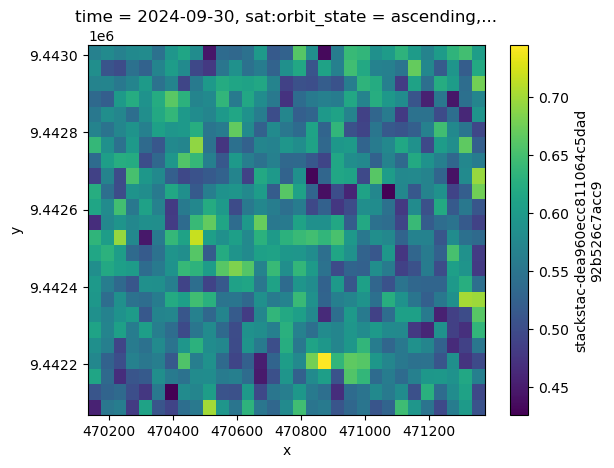

In [25]:
q_composite = utils.quartely_composite(coarsened)
q_composite

index = utils.calculate_index(q_composite, "mRFDI")

# TO do- values within subzones
#index.isel(time=0).plot.imshow()
# fig, ax = plt.subplots(nrows=4, ncols=4)

# index.isel(time=-2).plot.imshow(ax = ax[0, 0])
# index.isel(time=-3).plot.imshow(ax = ax[0, 1])
# index.isel(time=-4).plot.imshow(ax = ax[0, 2])
# index.isel(time=-5).plot.imshow(ax = ax[0, 3])


index.isel(time=-2).plot.imshow()

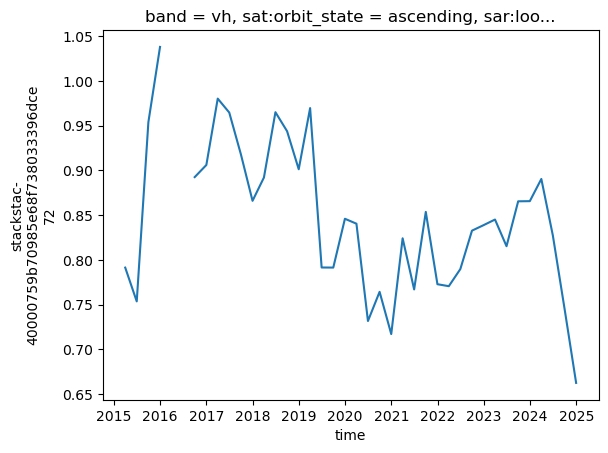

In [15]:
tsmean = index.mean(dim = ['y', 'x'], skipna = True) 

tsmean.plot()
# fig, ax = plt.subplots()
# tsmean.plot.scatter(ax=ax)
# plt.draw()

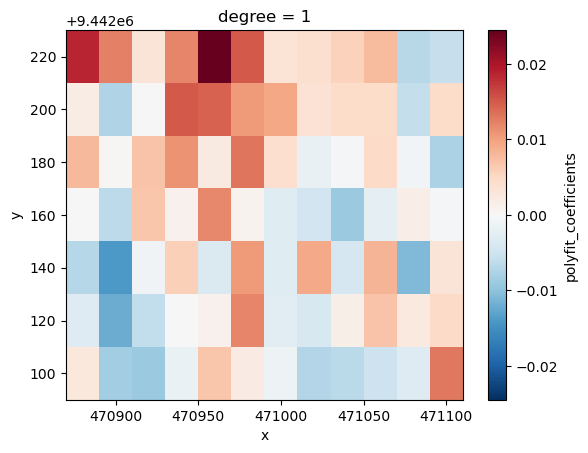

In [53]:
trends = utils.linear_trend(index)
linecoeff = trends.sel(degree = 1)

linecoeff.polyfit_coefficients.plot.imshow()